In [20]:
import mysql.connector as connector
import sklearn
import datetime 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost
import numpy as np
import pickle

from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

## SQL Connection & Import

In [2]:
conn = connector.connect(user='root', password='123456', host='localhost', port='3306', database='my_db')

mycursor = conn.cursor()

In [3]:
mycursor.execute('SELECT * FROM price_sentiment')
result = mycursor.fetchall()
df = pd.DataFrame(result, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Score', 'Positive' , 'Negative', 'Neutral', 'Total_Sentiment'])

df.set_index('Date', drop = True, inplace=True)
date = df.index
df.drop(['Open', 'High', 'Low', 'Dividends', 'Stock_Splits', 'Score'], inplace=True, axis=1)

In [4]:

df

,Close,Volume,Positive,Negative,Neutral,Total_Sentiment
Date,,,,,,
2014-01-06,0.374438,409492000.0,0,0,1,0.00000
2014-04-23,0.452159,261580000.0,0,1,0,-1.00000
2015-06-01,0.541710,372660000.0,0,0,1,0.00000
2016-01-05,0.802491,490272000.0,1,0,0,1.00000
2016-09-28,1.642590,319788000.0,0,0,1,0.00000
...,...,...,...,...,...,...
2025-02-24,130.280000,251381000.0,3,4,12,2.78947
2025-02-25,126.630000,271429000.0,6,5,10,5.76190
2025-02-26,131.280000,322554000.0,14,7,20,13.82930


### Data Processing

In [5]:
df['Close'] = df['Close'].shift(-1)
df.dropna(inplace=True)

<Axes: >

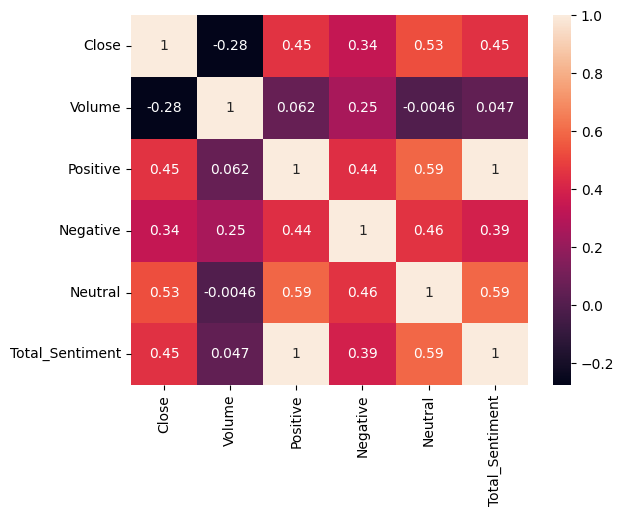

In [7]:
sns.heatmap(df.corr(),annot=True)

### Function train test split

In [ ]:
#def traintest(data):

    #X = data.drop(columns=['Close'], axis = 1)
X= df.drop(['Close'],axis=1)
Y = df['Close']
    
X_train = X.iloc[0:int(0.7*len(X))]
Y_train = Y.iloc[0:int(0.7*len(Y))]

X_test = X.iloc[int(0.7*len(X)):len(X)]
Y_test = Y.iloc[int(0.7*len(Y)):int(len(Y))]

In [ ]:
df_date = df.index
df_columns = df.columns
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#df_transformed.columns = df_columns
#df_transformed.set_index(df_date, inplace=True)


## Linear Regression

In [106]:
#X_train, X_test, Y_train,Y_test = traintest(df_transformed)

model=LinearRegression()

model.fit(X_train_scaled, Y_train)

y_pred = model.predict(X_test_scaled)

In [108]:
r2 = sklearn.metrics.r2_score(Y_test, y_pred)
print(r2)

mse = mean_squared_error(Y_test, y_pred)
print(mse)


-2.248874651131986
5316.055119246763


In [116]:
prediction = pd.DataFrame({
    'Date': Y_test.index,
    'Prediction': y_pred
})

In [119]:
prediction.set_index('Date',drop=True,inplace=True)

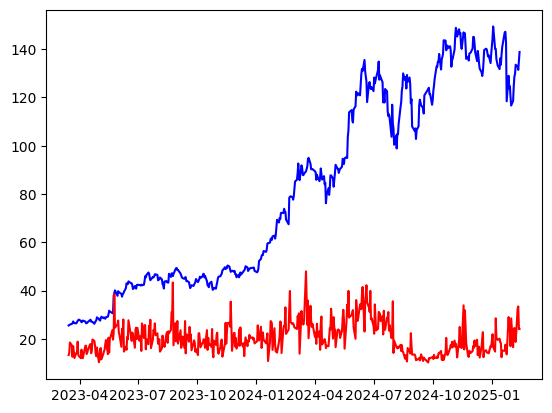

In [120]:
plt.plot(Y_test,color='blue')
plt.plot(prediction,color='red')
plt.show()

In [ ]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = model.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6],
    'model__fit_intercept': [True, False]
}

In [ ]:
X = df.drop('Close', axis=1)

Y= df['Close']

In [ ]:
# 🔹 Perform Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1  # Using R² as the metric
)

grid_search.fit(X, Y)  # Flatten Y to 1D array

print(f"Best Polynomial Degree: {grid_search.best_params_['poly__degree']}")
print(f"Best R² Score: {grid_search.best_score_:.4f}")

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, Y_train,Y_test = traintest(df_transformed)

dt = DecisionTreeRegressor()

dt.fit(X_train, Y_train)

y_pred = dt.predict(X_test)

r2 = r2_score(Y_test, y_pred)

print(r2)

mse = mean_squared_error(Y_test, y_pred)
print(mse)

In [ ]:
plt.scatter(Y_test,y_pred, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [ ]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

In [ ]:
parameter ={
    'max_depth': [10,20,30,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':[1,2,4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=parameter, cv=5,n_jobs=-1,  scoring='neg_mean_squared_error')

grid_search.fit(X_train, Y_train)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
print(mse)

In [ ]:
import numpy as np

X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

In [ ]:
X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = best_dt.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train,Y_train)

rf_pred = rf.predict(X_test)

r2 = r2_score(Y_test,rf_pred)
print(r2)

mse = mean_squared_error(rf_pred, Y_test)
print(mse)

In [ ]:
plt.scatter(Y_test,y_pred, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [ ]:
X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = rf.predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

In [ ]:
parameter ={
    'n_estimators':[100,200,300,400,500],
    'max_depth': [2,5,10,20,30, None],
    'min_samples_split':[2,5,10,20,30],
    'min_samples_leaf':[1,2,5,10,20,30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=parameter,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)


In [ ]:
best_rf = grid_search.best_estimator_

rf_pred = best_rf.predict(X_test)

mse = mean_squared_error(rf_pred, Y_test)
print(mse)

In [ ]:
X = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = best_rf .predict(X)

temp = np.array([[prediction[0], X[0, 0], X[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

In [ ]:
df_transformed.index = pd.to_datetime(df_transformed.index)

df_transformed.index = df_transformed.index.strftime('%d-%m-%Y')

## XGBoost

In [84]:
X= df_transformed.drop(['Close'],axis=1)
Y = df_transformed['Close']

In [91]:
xg = XGBRegressor()

cv = RepeatedKFold(n_repeats=3, random_state=1)
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

scores = absolute(scores)

print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.138 (0.007)


In [92]:
xg.fit(X_train,Y_train)

y_pred = xg.predict(X_test)

r2 = r2_score(Y_test,y_pred)

print(r2)

-2.6260919108154797


## Deep Neural Network

In [ ]:
dnn = Sequential()
dnn.add(Dense(units=128, activation = 'relu', input_dim=5))
dnn.add(Dense(units=32, activation = 'relu'))
dnn.add(Dense(units=8, activation = 'relu'))
dnn.add(Dense(units=1, activation = 'linear'))

In [ ]:
dnn.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode = 'min',verbose=1, patience=200)

In [ ]:
history = dnn.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
prediction = dnn.predict(X_test) 

In [ ]:
print(r2_score(Y_test,prediction))

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(Y_test,prediction, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

## LSTM

In [21]:
scaler = StandardScaler()

In [22]:
df_train = df.iloc[0:int(0.8*len(df))]
df_test = df.iloc[int(0.8*len(df)):len(df)]

In [23]:
df_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.fit_transform(df_test)

In [24]:
df_scaled.shape

(1280, 6)

In [25]:
trainX = []
trainY = []

n_past = 14
n_future = 1

for i in range(n_past, len(df_scaled)-n_future+1):
    trainX.append(df_scaled[i-n_past: i ,0:df_scaled.shape[1]])
    trainY.append(df_scaled[i + n_future - 1:i + n_future,0])

In [26]:
df_test.shape

(321, 6)

In [27]:
# split data for testing data

testX = []
testY = []

for i in range(n_past, len(df_test_scaled)-n_future+1):
    testX.append(df_test_scaled [i-n_past: i , 0: df_test_scaled.shape[1]])
    testY.append(df_test_scaled [i + n_future - 1:i + n_future,0])

In [28]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [29]:
testX, testY = np.array(testX), np.array(testY)

In [30]:
trainX.shape

(1266, 14, 6)

In [31]:
trainY.shape

(1266, 1)

In [32]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
history = model.fit(trainX, trainY, epochs=150,  validation_split=0.1, batch_size=32,callbacks=[early_stopping])

Epoch 1/150


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2568 - val_loss: 3.1196
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0308 - val_loss: 4.9432
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0261 - val_loss: 0.8735
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0224 - val_loss: 4.2156
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0247 - val_loss: 1.1113
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0239 - val_loss: 3.9548
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0237 - val_loss: 2.8459
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0215 - val_loss: 1.0744


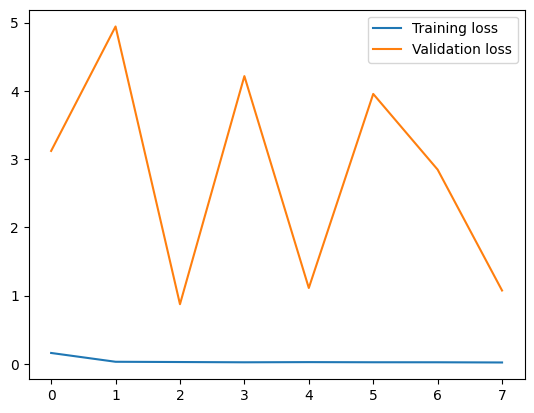

In [36]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [37]:
prediction = model.predict(testX)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


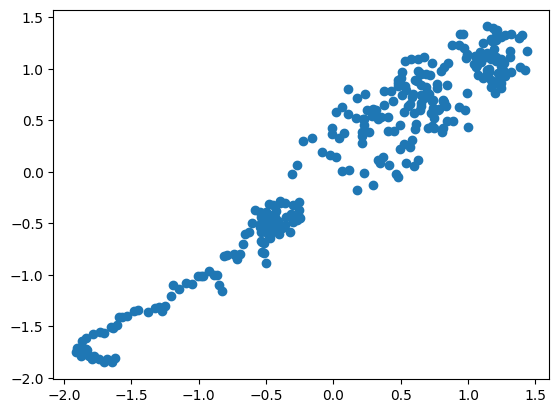

In [38]:
plt.scatter(prediction,testY)

In [39]:
r2 =r2_score(testY,prediction)

print(r2)

0.9400775025940116


In [40]:
filename = 'finalized_model.sav'

pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [41]:
trainfuture = df_test_scaled[-14: ,]

In [42]:
trainfuture = trainfuture.reshape(1, 14, 6)

In [43]:
prediction = model.predict(trainfuture)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [44]:
prediction

array([[0.81223845]], dtype=float32)

In [45]:
arr = [prediction.flatten()[0],  prediction.flatten()[0], prediction.flatten()[0], prediction.flatten()[0], prediction.flatten()[0], prediction.flatten()[0]]

In [46]:
arr

[np.float32(0.81223845),
 np.float32(0.81223845),
 np.float32(0.81223845),
 np.float32(0.81223845),
 np.float32(0.81223845),
 np.float32(0.81223845)]

In [47]:
arr = np.array(arr).reshape(1,-1)

In [48]:
y_pred_future = scaler.inverse_transform(arr)

In [49]:
y_pred_future 

array([[1.3036906e+02, 4.9766099e+08, 7.1801863e+00, 3.7065089e+00,
        1.2310371e+01, 7.0428982e+00]], dtype=float32)

In [52]:
print('The predicted price for the next day:', y_pred_future[0][0])

The predicted price for the next day: 130.36906


In [50]:
conn.close()

mycursor.close()

True